In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms

import copy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm





In [4]:
N, D_in, D_out = 100, 2, 1


# m =1
X2 = []
y2 = []
for j in range(N):
    X2.append([])
    #y.append([])
    for i in range(D_out):
        X2[-1].append( 1 )
        X2[-1].append( np.random.uniform(low=-10.0, high=10.0, size=None) )
        y2.append( (X2[-1][-1]**2) / (2*X2[-1][-2])  )


X2 = torch.Tensor(X2)
y2 = torch.Tensor(y2)


# p =1
X3 = []
y3 = []
for j in range(N):
    X3.append([])
    #y.append([])
    for i in range(D_out):
        X3[-1].append( np.random.uniform(low=0.1, high=10.0, size=None) )
        X3[-1].append( 1 )
        y3.append( (X3[-1][-1]**2) / (2*X3[-1][-2])  )


X3 = torch.Tensor(X3)
y3 = torch.Tensor(y3)

# X2_test = torch.tensor(X2, dtype=torch.float32)
# y2_test = torch.tensor(y2, dtype=torch.float32).reshape(-1, 1)
# X3_test = torch.tensor(X3, dtype=torch.float32)
# y3_test = torch.tensor(y3, dtype=torch.float32).reshape(-1, 1)

In [6]:

# X = torch.load('/content/drive/MyDrive/0_318lab/SCMP_ML/KEdataX_1000_1691036428.pt')
# y = torch.load('/content/drive/MyDrive/0_318lab/SCMP_ML/KEdataY_1000_1691036428.pt')

X = torch.load('/content/drive/MyDrive/0_318lab/SCMP_ML/data/KEdataX_N_10000_Interval_10_1691050560.pt')
y = torch.load('/content/drive/MyDrive/0_318lab/SCMP_ML/data/KEdataY_N_10000_Interval_10_1691050560.pt')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)
# X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, train_size=0.7, shuffle=True)
# X3_train, X3_test, y3_train, y3_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Convert to 2D PyTorch tensors
#X_train = torch.tensor(X_train, dtype=torch.float32)
#y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
#X_test = torch.tensor(X_test, dtype=torch.float32)
#y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)




In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X2, y2, train_size=0.7, shuffle=False)


In [7]:
# df = px.data.iris()
# fig = px.scatter_3d(x=X[:,0], y=X[:,1], z=y, size=torch.ones(len(y_pred))*0.001)
fig = px.scatter_3d(x=X_train[:,0], y=X_train[:,1], z=y_train) #size=torch.ones(len(y_pred))*0.001)
fig.update_traces(marker_size=1)
fig.show()

In [17]:
print(len_batch)

100


start
epoch:     0 , test_loss: 927.62 , train_loss: 294.02 , est_time: 0.011 min, average_time: 0.6726176738739014 s
epoch:   100 , test_loss: 2559.83 , train_loss: 178.78 , est_time: 0.247 min, average_time: 0.14644657975376243 s
epoch:   200 , test_loss: 4009.90 , train_loss: 105.16 , est_time: 0.466 min, average_time: 0.13897172372732589 s
epoch:   300 , test_loss: 1255.70 , train_loss: 407.25 , est_time: 0.675 min, average_time: 0.13446158903381752 s
epoch:   400 , test_loss: 1294.66 , train_loss: 150.07 , est_time: 0.908 min, average_time: 0.13579722057256913 s
epoch:   500 , test_loss: 720.87 , train_loss: 489.97 , est_time: 1.119 min, average_time: 0.134050032335841 s
epoch:   600 , test_loss: 3729.67 , train_loss: 70.25 , est_time: 1.336 min, average_time: 0.13336725282589726 s
epoch:   700 , test_loss: 1884.09 , train_loss: 75.54 , est_time: 1.548 min, average_time: 0.1325036414849775 s
epoch:   800 , test_loss: 10276.80 , train_loss: 77.13 , est_time: 1.764 min, average_time

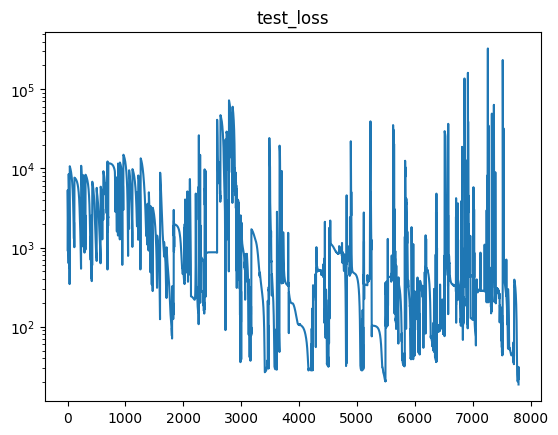

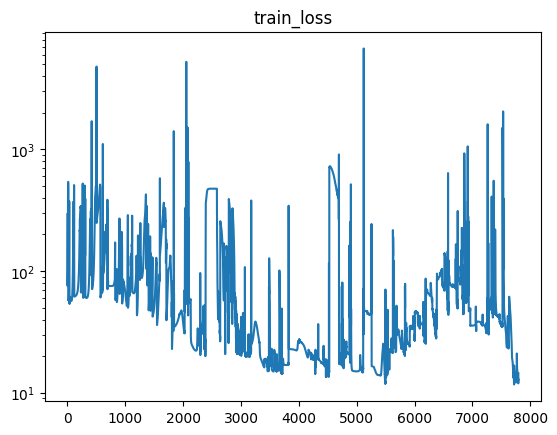

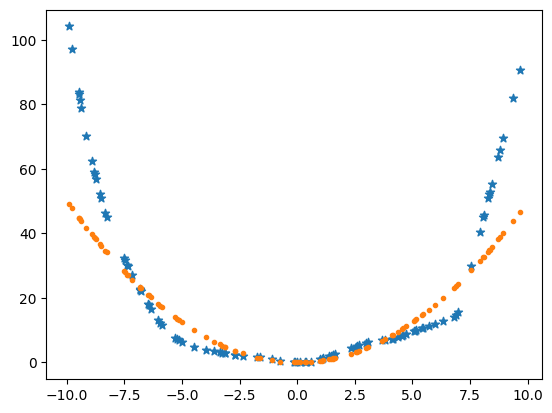

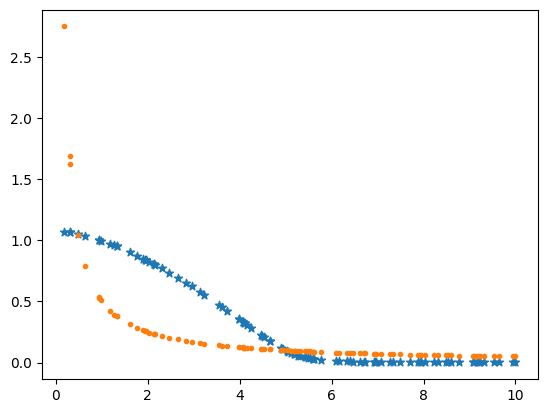

finish--------------------------------------------------------------------------------------------------------------------------------------------------------

all done


In [19]:

#default

"""
try

activateion: Softplus , optimizer: Adam , n_of_data: 100 , Bsize: 100 , learningRate: 0.0005 , minimum_RMSE: 27.47 , epoch:  3660 , test_loss: 595.456665 , train_loss: 14.215258 , layer_dim_list: [2, 20, 20, 20, 20, 1] , passed_time: 5.000 m , passed_time: -160.696 s

activateion: Softplus , optimizer: Adam , n_of_data: 100 , Bsize: 100 , learningRate: 5e-05 , minimum_RMSE: 252.92 , epoch:  3668 , test_loss: 256.572418 , train_loss: 184.996445 , layer_dim_list: [2, 20, 20, 20, 20, 1] , passed_time: 5.000 m , passed_time: -170.736 s

activateion: Softplus , optimizer: Adam , n_of_data: 100 , Bsize: 10 , learningRate: 0.005 , minimum_RMSE: 77.75 , epoch:   386 , test_loss: 3821.791748 , train_loss: 5.220962 , layer_dim_list: [2, 20, 20, 20, 20, 1] , passed_time: 5.010 m , passed_time: -30.134 s

activateion: Softplus , optimizer: Adam , n_of_data: 100 , Bsize: 500 , learningRate: 0.001 , minimum_RMSE: 22.67 , epoch: 13813 , test_loss: 15479.684570 , train_loss: 1186.494629 , layer_dim_list: [2, 20, 20, 20, 20, 1] , passed_time: 5.000 m , passed_time: -205.868 s

"""
# for learningRate in range(10): #


dim_list = [2, 20, 20, 20, 20, 1]



#If data is less complex and is having fewer dimensions or features then neural networks with 1 to 2 hidden layers would work.
# If data is having large dimensions or features then to get an optimum solution, 3 to 5 hidden layers can be used.

init_time = time.time()
print('start')
for act in [
            # 'LeakyReLU',
            # 'LogSigmoid',
            'Softplus']:

    for opt in [
                # 'Adadelta',
                # 'Adagrad',
                'Adam',
                # 'AdamW',
                # 'SparseAdam',
                # 'Adamax',
                # 'ASGD',
                # 'LBFGS',
                # 'NAdam',
                # 'RAdam',
                # 'RMSprop',
                # 'Rprop',
                # 'SGD'
                ]:
    # try:
        # if opt == 'Adam':# ---------------delete later----------------------------------------------------------------------------------------------------------------------------------------------
        #     continue# ---------------delete later----------------------------------------------------------------------------------------------------------------------------------------------
        # for Bsize in [ 10, 50, 100, 500]:
        # for Bsize in [ 10, 100, 1000]:
        for Bsize in [ 100]:
            # print('Bsize:', Bsize, end =' ')
            #before_loss_twos =  torch.ones(Bsize, dtype=torch.float32)*2
            # for learningRate in [ 1e-1, 1e-2, 1e-3, 1e-4,1e-5, 1e-6, ]:
            # for learningRate in [ 1e-1, 5e-1, 1e-2, 5e-2, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 5e-5, 1e-6, 5e-6, ]:
            for learningRate in [   0.0005 ]:
                # print('learningRate:', learningRate)
                # Define the model

                make_model = 'model = nn.Sequential('
                for layer_num in range( len(dim_list) - 1 ):
                    if layer_num == len(dim_list) - 2:
                        make_model = make_model + 'nn.Linear(dim_list[' + str(layer_num) + '], dim_list[' + str(layer_num+1) + ']) )'
                    else:
                        # make_model = make_model + 'nn.Linear(dim_list[' + str(layer_num) + '], dim_list[' + str(layer_num+1) + ']), nn.LeakyReLU(),'
                        make_model = make_model + 'nn.Linear(dim_list[' + str(layer_num) + '], dim_list[' + str(layer_num+1) + ']), nn.' + act + '(),'


                exec(make_model)
                #make_model = make_model +

                # model = nn.Sequential(
                #     nn.Linear(dim_list[0], dim_list[1]),
                #     nn.LeakyReLU(),
                #     nn.Linear(dim_list[1], dim_list[2]),
                #     nn.LeakyReLU(),
                #     nn.Linear(dim_list[2], dim_list[3])
                #     # nn.Linear(2, 3),
                #     # nn.LeakyReLU(),
                #     # nn.Linear(3, 2),
                #     # nn.LeakyReLU(),
                #     # nn.Linear(2, 1)
                # )

                # loss function and optimizer
                # loss_fn = nn.MSELoss()  # mean square error
                # optimizer = optim.Adam(model.parameters(), lr=learningRate  )  # 10 loss: 5157042688.0
                exec('optimizer = optim.' + opt + '(model.parameters(), lr=learningRate  )')
                # n_epochs = 20000+1   # number of epochs to run
                batch_size = Bsize  # size of each batch
                batch_start = torch.arange(0, len(X_train), batch_size)

                # Hold the best model
                best_mse = np.inf   # init to infinity
                best_weights = None
                history = []
                history_train = []


                # for epoch in range(n_epochs):
                second_time = time.time()

                epoch = 0
                len_batch = len(X_train)
                while(1):

                    model.train()
                    # with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                        # print(bar)
                        # bar.set_description(f"Epoch {epoch}")
                        # for start in bar:

                    for start in range(0,len_batch, batch_size):
                        # print(start)
                        # take a batch
                        X_batch = X_train[start:start+batch_size] # 두번째 값이 길이를 초과해도 오류안뜨고 그냥 시작부터 끝까지 출력해주는 착한친구.
                        y_batch = y_train[start:start+batch_size]
                        # forward pass
                        y_pred = model(X_batch).squeeze()

                        before_loss = torch.mean( (y_pred/y_batch-1)**2 + (y_batch/y_pred-1)**2 + (y_pred-y_batch)**2 )
                        # before_loss_twos =  torch.ones(len(y_pred), dtype=torch.float32)*2


                        loss = before_loss**(1/2)
                        # loss = loss_fn(y_pred, y_batch)
                        # loss = loss_fn(before_loss, before_loss_twos + y_batch)

                        # backward pass
                        optimizer.zero_grad()
                        loss.backward()

                        # update weights
                        optimizer.step()
                        # print progress
                        # bar.set_postfix(mse=float(loss))
                    #print(y_pred)
                    loss = float(loss)

                    history_train.append(loss)
                    # evaluate accuracy at end of each epoch
                    model.eval()
                    y_pred = model(X_test).squeeze()
                    #print(y_pred)

                    before_loss = torch.mean(  (y_pred/y_test-1)**2 + (y_test/y_pred-1)**2 + (y_pred-y_test)**2 )
                    # before_loss = y_pred/y_test + y_test/y_pred + y_pred
                    # before_loss_twos =  torch.ones(len(y_pred), dtype=torch.float32)*2
                    # mse = loss_fn(y_pred, y_test)
                    # mse = loss_fn(before_loss, before_loss_twos + y_test)
                    mse = before_loss**(1/2)

                    mse = float(mse)

                    history.append(mse)
                    if mse < best_mse:
                        best_mse = mse
                        best_weights = copy.deepcopy(model.state_dict())

                    #epoch_time = ( time.time()-second_time )

                    #init_time = time.time()
                    if epoch % 100 == 0:
                        # print('epoch: %5d' % epoch, 'test_loss: %.2f' % (mse), 'train_loss: %.2f' % (loss), 'est_time: %.2f' % (( ( epoch_time ) / (epoch+1) ) / 60 * (n_epochs-epoch) ) ,'min', "epoch_time:", epoch_time, 's')
                        print('epoch: %5d' % epoch, ', test_loss: %.2f' % (mse), ', train_loss: %.2f' % (loss), ', est_time: %.3f' % ( ( ( time.time()-second_time ) )  / 60  ) ,'min,', "average_time:", ( time.time()-second_time )/(epoch+1), 's')
                        # print('{:.6}'.format(val))

                    if (mse<20) or (str(mse)=='nan') or ( ( ( time.time()-second_time ) )  / 60 > 1  ):
                        break
                    epoch = epoch + 1

                # restore model and return best accuracy
                model.load_state_dict(best_weights)
                # print("MSE: %.2f" % best_mse)
                # print("RMSE: %.2f" % np.sqrt(best_mse))
                print(
                      ', layer_dim_list:', dim_list,
                      'activateion:', act,
                      ', optimizer:', opt,
                      ', n_of_data:',N,
                      ', Bsize:', Bsize ,
                      ', learningRate:', learningRate ,
                      )
                print(
                      ', epoch: %5d' % epoch,
                      ', passed_time: %.3f' % ( ( ( time.time()-second_time ) )  / 60  ),  'm',

                      ", minimum_RMSE: %.2f" % (best_mse),
                      ', test_loss: %2f' % (mse),
                      ', train_loss: %2f' % (loss),
                      ', passed_time_accum: %.3f' % ( ( init_time - time.time() )  / 60  ),  'm'
                      )
                # print(y_pred[:10])
                # print(y_test[:10])
                plt.plot(history)
                plt.yscale('log')
                plt.title('test_loss')
                plt.show()

                plt.plot(history_train)
                plt.title('train_loss')
                plt.yscale('log')
                plt.show()

                model.eval()
                y_pred = model(X2)
                plt.scatter(X2[:,1].cpu().detach().numpy(),y_pred.cpu().detach().numpy(), marker='*')
                plt.scatter(X2[:,1] ,y2, marker='.', )
                plt.show()

                model.eval()
                y_pred = model(X3)
                plt.scatter(X3[:,0].cpu().detach().numpy(),y_pred.cpu().detach().numpy(), marker='*')
                plt.scatter(X3[:,0] ,y3, marker='.', )
                plt.show()

                print('finish--------------------------------------------------------------------------------------------------------------------------------------------------------')
                print('')

    # except:
    #     print('error when:', opt, 'error when:', opt, 'error when:', opt, 'error when:', opt, 'error when:', opt, 'error when:', opt, 'error when:', opt, 'error when:', opt, 'error when:', opt, 'error when:', opt, 'error when:', opt, )
print('all done')
# ----------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------

In [20]:
y_pred[:10]

tensor([[8.0313e-04],
        [1.4477e-02],
        [5.2335e-04],
        [6.4915e-01],
        [1.1275e-01],
        [1.0513e+00],
        [3.6083e-02],
        [6.2214e-01],
        [9.7203e-01],
        [5.2085e-03]], grad_fn=<SliceBackward0>)

In [21]:
y_test[:10]

tensor([45.7066,  0.1204,  3.6408,  3.5518,  0.4243,  4.7800,  0.3298, 14.3999,
         3.6568,  9.6952])

In [34]:
X2[:,1].cpu().detach().numpy(),y_pred.cpu().detach().numpy()

(array([-9.412401  , -8.597599  ,  8.400644  ,  6.8254766 , -0.43420464,
         8.041001  ,  7.1967516 ,  4.1458616 ,  6.0354137 ,  0.4292564 ,
         4.007263  ,  6.8671265 , -7.288635  , -6.331317  , -3.0597212 ,
         1.2955757 , -6.5988264 ,  5.6098967 , -6.5094194 ,  5.596743  ,
        -4.192074  , -6.46193   ,  7.148575  ,  0.435902  ,  0.99081063,
         8.692309  , -7.454913  , -1.6519917 , -1.002991  ,  1.9762822 ,
         8.370339  , -4.8005805 , -5.811991  , -2.0163386 , -7.1919475 ,
        -3.1679535 ,  5.0242248 , -5.9196005 ,  6.4301214 , -0.30888075,
        -7.3667192 , -2.2594132 ,  1.6686121 ,  7.781054  ,  4.060164  ,
         6.450592  , -3.2082021 ,  2.7960634 ,  1.3098203 , -6.2025604 ,
         6.01309   , -8.770753  ,  4.812663  ,  8.741615  ,  3.7727764 ,
        -2.8010192 , -5.6665053 ,  5.7944903 ,  0.2814901 , -9.780003  ,
        -8.143642  , -8.849931  , -8.785208  ,  7.6841173 ,  5.1416807 ,
         0.16715692, -9.813547  , -8.890595  ,  3.4

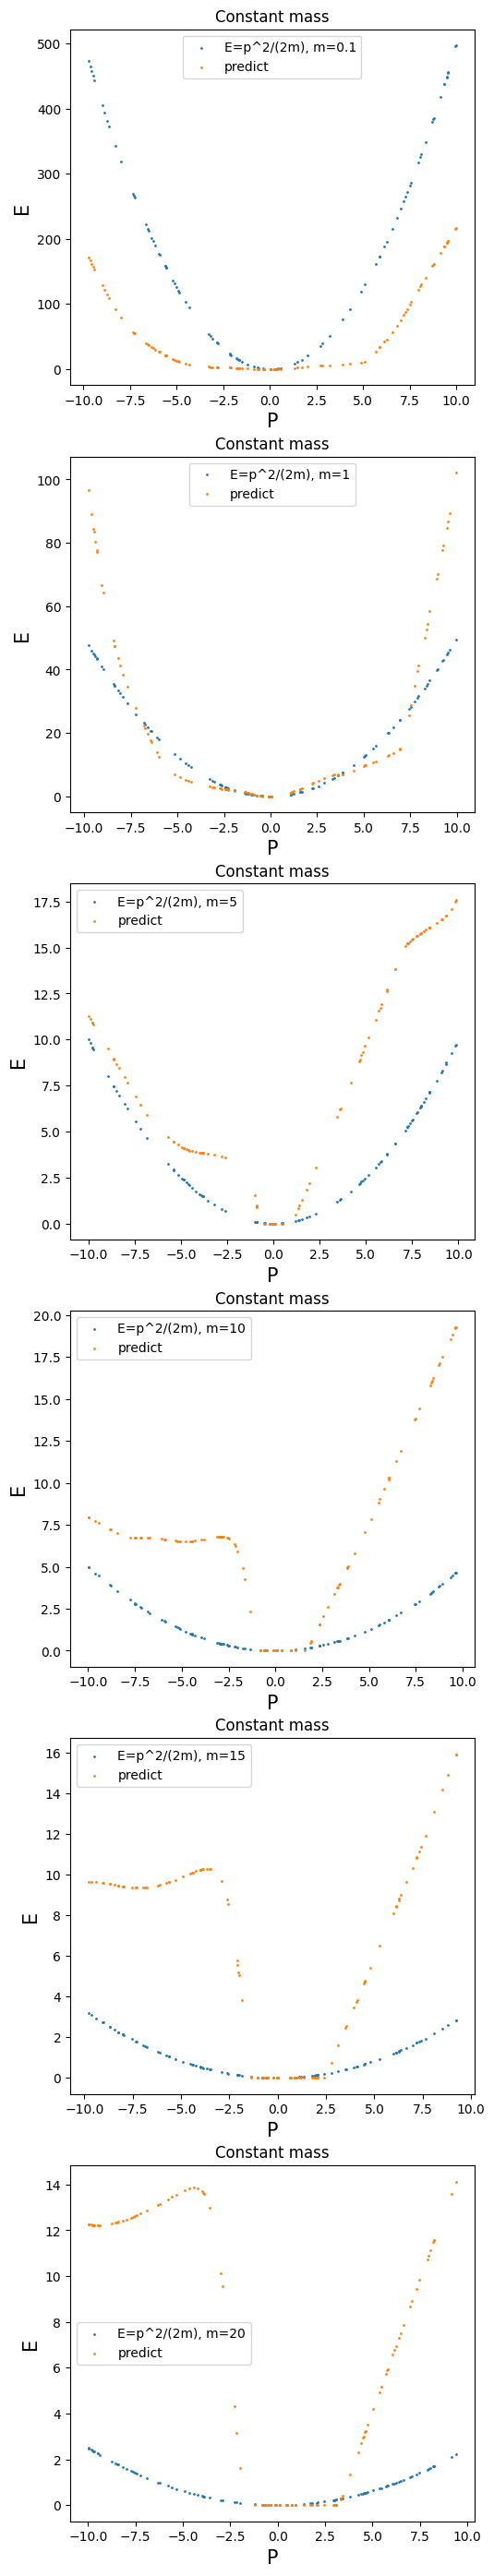

In [45]:
N, D_in, D_out = 100, 2, 1

mass_num = [0.1, 1, 5, 10, 15, 20]
len_mass_num = len(mass_num)
fig, axs = plt.subplots(len_mass_num, 1, figsize=(5, 5*len_mass_num))#, sharey=True)
for k in range(len_mass_num):
    # m =1
    X2 = []
    y2 = []
    for j in range(N):
        X2.append([])
        #y.append([])
        for i in range(D_out):
            X2[-1].append( mass_num[k] )
            X2[-1].append( np.random.uniform(low=-10.0, high=10.0, size=None) )
            y2.append( (X2[-1][-1]**2) / (2*X2[-1][-2])  )


    X2 = torch.Tensor(X2)
    y2 = torch.Tensor(y2)



    model.eval()
    y_pred = model(X2)


    axs[k].scatter(X2[:,1], y2, label="E=p^2/(2m), m="+str(mass_num[k])+"", s=1)
    axs[k].scatter(X2[:,1].cpu().detach().numpy(), y_pred.cpu().detach().numpy(), label="predict", s=1)
    axs[k].legend()
    axs[k].set_xlabel('P', fontsize=15)
    axs[k].set_ylabel(r'E', fontsize=15)
    # plt.ylabel("Y", rotation=0)
    axs[k].set_title('Constant mass')

plt.subplots_adjust(bottom=0.1, right=1, top=1)
    # axs[2].plot(names, values)
# fig.suptitle('Constant mass')


# ax.set_title('Volume and percent change')
# plt.savefig('/content/drive/MyDrive/0_318lab/SCMP_ML/figures/' + str('test') + '.png')
plt.savefig(
            '/content/drive/MyDrive/0_318lab/SCMP_ML/figures/' + str('test') + '_'+str(int(time.time()))+'.pdf',
            format="pdf",
            bbox_inches="tight")

plt.show()



# # p =1
# X3 = []
# y3 = []
# for j in range(N):
#     X3.append([])
#     #y.append([])
#     for i in range(D_out):
#         X3[-1].append( np.random.uniform(low=0.1, high=10.0, size=None) )
#         X3[-1].append( 2 )
#         y3.append( (X3[-1][-1]**2) / (2*X3[-1][-2])  )


# X3 = torch.Tensor(X3)
# y3 = torch.Tensor(y3)


# model.eval()
# y_pred = model(X3)
# plt.scatter(X3[:,0].cpu().detach().numpy(),y_pred.cpu().detach().numpy(), marker='*')
# # plt.scatter(X3[:,1],y_pred, marker='*')
# plt.show()


# plt.scatter(X3[:,0] ,y3, marker='.', )
# plt.show()

# plt.scatter(X3[:,0].cpu().detach().numpy(),y_pred.cpu().detach().numpy(), marker='*')
# plt.scatter(X3[:,0] ,y3, marker='.', )
# plt.show()


# print('all done')


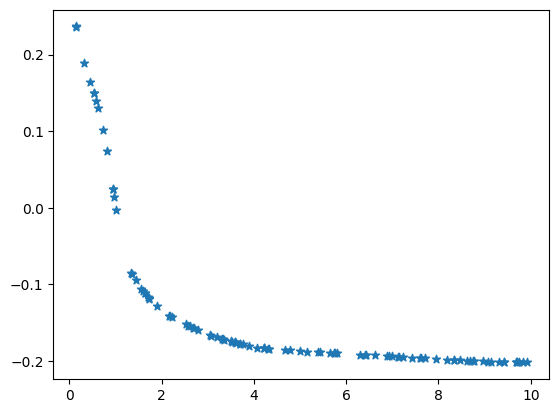

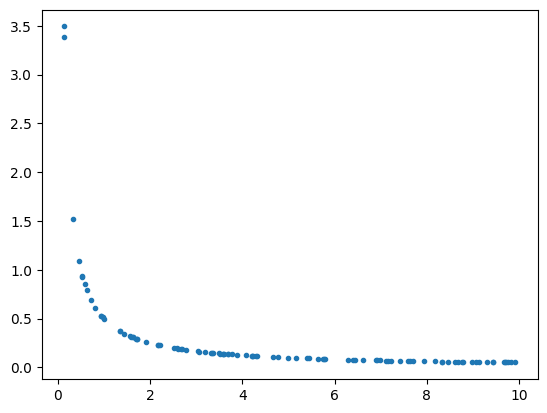

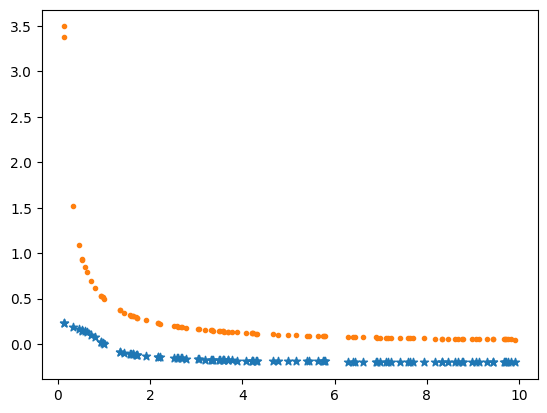

all done


In [ ]:

print('all done')

In [ ]:
plt.plot(history)
plt.yscale('log')
plt.title('test_loss')
plt.show()

plt.plot(history_train)
plt.title('train_loss')
plt.yscale('log')
plt.show()

NameError: ignored

In [ ]:
# when create new data

# N, D_in, H, D_out = 64, 1000, 100, 10
for m in [10, 100, 1000]:
    for k in [1000, 10000, 100000]:
        N, D_in, D_out = k, 2, 1

        # 입력과 출력 위한 랜덤 텐서
        X = []
        y = []
        for j in range(N):
            X.append([])
            #y.append([])
            for i in range(D_out):
                X[-1].append( np.random.uniform(low=0.1, high=10.0, size=None) )
                X[-1].append( np.random.uniform(low=-m, high=m, size=None) )
                y.append( (X[-1][-1]**2) / (2*X[-1][-2])  )


        X = torch.Tensor(X)
        y = torch.Tensor(y)

        # nn package를 이용하여 여러 층으로 정의된 모델 생성
        # nn.Sequential은 다른 모듈을 담을 수 있는 모듈이며 담겨진 모듈은 순서대로 연결
        # Linear 모듈은 곧 Affine 모듈

        # Read data
        # data = fetch_california_housing()
        # X, y = data.data, data.target

        # train-test split for model evaluation

        # import time
        # >>> # Save to file
        # >>> x = torch.tensor([0, 1, 2, 3, 4])
        # >>> torch.save(x, 'tensor.pt')

        torch.save(X, '/content/drive/MyDrive/0_318lab/SCMP_ML/'+'KEdataX_N_'+ str(N) +'_Interval_'+str(m)+'_'+str(int(time.time()))+'.pt' )
        torch.save(y, '/content/drive/MyDrive/0_318lab/SCMP_ML/'+'KEdataY_N_'+ str(N) +'_Interval_'+str(m)+'_'+str(int(time.time()))+'.pt' )
